In [1]:
import cv2
import os

def extract_frames_from_video_segment(video_path, start_time, end_time, output_dir, frame_rate=None):
    """
    Извлекает кадры из определенной части видео.

    Args:
        video_path (str): Путь к видеофайлу.
        start_time (float): Начальное время в секундах.
        end_time (float): Конечное время в секундах.
        output_dir (str): Директория для сохранения кадров.
        frame_rate (float, optional): Частота кадров. Если не указана,
                                      используется частота видео.
    """

    # Проверка существования директории
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Открытие видеофайла
    video_capture = cv2.VideoCapture(video_path)

    if not video_capture.isOpened():
        print(f"Ошибка открытия видео: {video_path}")
        return

    # Определение частоты кадров
    if frame_rate is None:
        frame_rate = video_capture.get(cv2.CAP_PROP_FPS)
    # Преобразование времени в кадры
    start_frame = int(start_time * frame_rate)
    end_frame = int(end_time * frame_rate)

    # Перемещение к начальному кадру
    video_capture.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    current_frame = start_frame
    while True:
        ret, frame = video_capture.read()
        current_time = current_frame/frame_rate
        if not ret or current_frame > end_frame:
            break

        # Формирование имени файла
        file_name = os.path.splitext(os.path.basename(video_path))[0]
        output_path = os.path.join(output_dir, file_name+"_"+str(current_frame)+"_"+str(current_time)+".jpg")
        # Сохранение кадра
        cv2.imwrite(output_path, frame)


        current_frame += 1

    video_capture.release()

In [2]:
import json

In [3]:
def get_subdirectories(directory):
    return [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]

video_dirs_list_train = get_subdirectories('data_train_short/')
video_dirs_list_test = get_subdirectories('data_test_short/')

In [4]:
timings_train = "labels_json/train_labels.json"
with open(timings_train, 'r',encoding='utf-8') as fcc_file: 
    fcc_data_train = json.load(fcc_file)
    #print(json.dumps(fcc_data, indent=4))

def get_sec(time_str):
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

In [5]:
timings_test = "labels_json/test_labels.json"
with open(timings_test, 'r',encoding='utf-8') as fcc_file: 
    fcc_data_test = json.load(fcc_file)
    #print(json.dumps(fcc_data, indent=4))

for i in fcc_data_test:
    file_name = os.listdir('data_test_short/'+i)
    start_time = int(get_sec(fcc_data_test[i]["start"]))
    end_time = int(get_sec(fcc_data_test[i]["end"]))
    duration = end_time - start_time
    extract_frames_from_video_segment('data_test_short/'+i+"/"+file_name[0], start_time, end_time, "frames/validation/output_frames_OP")
    extract_frames_from_video_segment('data_test_short/'+i+"/"+file_name[0], end_time+1, end_time+1+duration, "frames/validation/output_frames_not_OP")

In [6]:

for i in fcc_data_train:
    file_name = os.listdir('data_train_short/'+i)
    start_time = int(get_sec(fcc_data_train[i]["start"]))
    end_time = int(get_sec(fcc_data_train[i]["end"]))
    duration = end_time - start_time
    extract_frames_from_video_segment('data_train_short/'+i+"/"+file_name[0], start_time, end_time, "frames/train/output_frames_OP")
    extract_frames_from_video_segment('data_train_short/'+i+"/"+file_name[0], end_time+1, end_time+1+duration, "frames/train/output_frames_not_OP")

In [7]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import skimage
from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

In [8]:
def data_transforms(phase):
    if phase == 'train':
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
    
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
        
    if phase == 'validation':
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
   
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])       
        
    return transform
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
image_datasets = {x: datasets.ImageFolder(os.path.join("frames/", x), data_transforms(x))
                  for x in ['validation','train']}

dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size = 4, shuffle=True), 
               'validation': torch.utils.data.DataLoader(image_datasets['validation'], batch_size = 1, shuffle=False)}

In [10]:
len(dataloaders['train'])

4258

In [11]:
len(dataloaders['validation'])

18582

In [12]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
classes = image_datasets['train'].classes
class_names = image_datasets['train'].classes

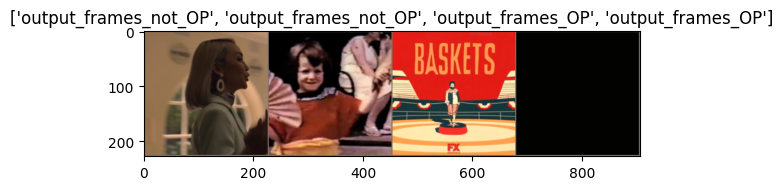

In [13]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [14]:
inputs, classes = next(iter(dataloaders['train']))

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        print("="*10)
        
        for phase in ['train', 'validation']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for data in dataloaders[phase]:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

In [16]:
model_pre = models.vgg19()

In [17]:
for param in model_pre.features.parameters():
    param.required_grad = False

num_features = model_pre.classifier[6].in_features
features = list(model_pre.classifier.children())[:-1] 
features.extend([nn.Linear(num_features, len(class_names))])
model_pre.classifier = nn.Sequential(*features) 
print(model_pre)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [18]:
model_pre = model_pre.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pre.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [19]:
model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=30)

Epoch: 1/30


C:\Users\Ainur\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train Loss: 0.6199 Acc: 0.6247
validation Loss: 0.6878 Acc: 0.5429
Epoch: 2/30
train Loss: 0.5366 Acc: 0.7199
validation Loss: 0.6493 Acc: 0.6121
Epoch: 3/30
train Loss: 0.4207 Acc: 0.8027
validation Loss: 0.5823 Acc: 0.6638
Epoch: 4/30
train Loss: 0.3006 Acc: 0.8691
validation Loss: 1.2354 Acc: 0.6879
Epoch: 5/30
train Loss: 0.2323 Acc: 0.9046
validation Loss: 0.9606 Acc: 0.7071
Epoch: 6/30
train Loss: 0.1794 Acc: 0.9332
validation Loss: 0.7479 Acc: 0.7446
Epoch: 7/30
train Loss: 0.1566 Acc: 0.9447
validation Loss: 1.0959 Acc: 0.7572
Epoch: 8/30
train Loss: 0.1355 Acc: 0.9529
validation Loss: 0.9575 Acc: 0.7276
Epoch: 9/30
train Loss: 0.1269 Acc: 0.9554
validation Loss: 1.0209 Acc: 0.6960
Epoch: 10/30
train Loss: 0.0579 Acc: 0.9775
validation Loss: 1.1002 Acc: 0.7397
Epoch: 11/30
train Loss: 0.0455 Acc: 0.9811
validation Loss: 0.9461 Acc: 0.7472
Epoch: 12/30
train Loss: 0.0417 Acc: 0.9827
validation Loss: 1.1758 Acc: 0.7427
Epoch: 13/30
train Loss: 0.0383 Acc: 0.9824
validation Loss: 

In [20]:
def test_model():
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    f = open("test_y", "w")
    with torch.no_grad():
        for data in dataloaders['validation']:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            true_labels.append(labels.item())
            outputs = model_pre(inputs)
            _, preds = torch.max(outputs.data, 1)
            pred_labels.append(preds.item())
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()
        acc = running_correct/running_total
    return (true_labels, pred_labels, running_correct, running_total, acc)

In [21]:
true_labels, pred_labels, running_correct, running_total, acc = test_model()

In [22]:
print("Total Correct: {}, Total Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)


Total Correct: 14327.0, Total Test Images: 18582.0
Test Accuracy:  0.7710149607146701
